In [1]:
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

import processing_io as pio
import sys
import os
import joblib
import json

import sys
import os
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch_geometric.data import Data, Batch
import torch
from torch_geometric.data import Data
import alphashape
from matplotlib.lines import Line2D

from shapely.geometry import Polygon
from torch.utils.data import DataLoader, Dataset, Subset

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

# Get the current working directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn  # or whatever you need to import
import help_functions as hf
import gnn_io as gio

In [2]:
run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_21_10_2024/'
point_net_conv_layer_structure_local_mlp = "64,128"
point_net_conv_layer_structure_global_mlp = "256,64"
gat_conv_layer_structure = "128,256,512,256"
dropout = 0.3
use_dropout = False 
predict_mode_stats = True
in_channels = 15
out_channels = 1 

pnc_l_string = point_net_conv_layer_structure_local_mlp.replace(',', '_')
pnc_g_string = point_net_conv_layer_structure_global_mlp.replace(',', '_') 
gat_string = gat_conv_layer_structure.replace(',', '_')

unique_model_description = f"pnc_local_[{pnc_l_string}]_" + \
f"pnc_global_[{pnc_g_string}]_" + \
f"gat_conv_[{gat_string}]_" + \
f"use_dropout_{use_dropout}_" + \
f"dropout_{dropout}_" + \
f"predict_mode_stats_{predict_mode_stats}" + "/"
        
run_path = run_path + unique_model_description

In [3]:
# Change this accordingly

districts_of_interest = [1, 2, 3, 4] # [5, 6, 7]
zone_to_plot = "zone_1" # "zone_2"
test_data = "../../data/test_data/gdf_pop_1pm_policy_in_1_2_3_4.geojson" # "../../data/test_data/gdf_pop_1pm_policy_in_5_6_7.geojson"
test_data = gpd.read_file(test_data)
base_case = "../../data/test_data/gdf_basecase_mean_pop_1pm.geojson"
base_case = gpd.read_file(base_case)    
    
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
indices_of_datasets_to_use = [0, 1, 3, 4]

scaler_x = joblib.load(data_created_during_training + 'train_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'train_pos_scaler.pkl')
scaler_mode_stats = joblib.load(data_created_during_training + 'train_mode_stats_scaler.pkl')

In [4]:
print("in_channels:", in_channels)
print("out_channels:", out_channels)

point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

print("point_net_conv_layer_structure_local_mlp:", point_net_conv_layer_structure_local_mlp)
print("point_net_conv_layer_structure_global_mlp:", point_net_conv_layer_structure_global_mlp)
print("gat_conv_layer_structure:", gat_conv_layer_structure)

in_channels: 15
out_channels: 1
point_net_conv_layer_structure_local_mlp: [64, 128]
point_net_conv_layer_structure_global_mlp: [256, 64]
gat_conv_layer_structure: [128, 256, 512, 256]


In [5]:
# Initialize the model

print("in_channels:", in_channels)
print("out_channels:", out_channels)
print("point_net_conv_layer_structure_local_mlp:", point_net_conv_layer_structure_local_mlp)
print("point_net_conv_layer_structure_global_mlp:", point_net_conv_layer_structure_global_mlp)
print("gat_conv_layer_structure:", gat_conv_layer_structure)

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

in_channels: 15
out_channels: 1
point_net_conv_layer_structure_local_mlp: [64, 128]
point_net_conv_layer_structure_global_mlp: [256, 64]
gat_conv_layer_structure: [128, 256, 512, 256]
Debug: Inside MyGnn.__init__
Debug: Initializing attributes
Debug: Creating PointNetConv layers
Debug: Creating PointNetConv instances
Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=66, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [ ]:
test_input_linegraph = pio.create_test_data_object(base_case=base_case, test_data = test_data) # check this function if there have been changes in the features of the data

In [ ]:
test_data_list = [test_input_linegraph] # we do it for just one test data object, for now.
# dataset_only_relevant_dimensions = gio.cut_dimensions(dataset=test_data_list, indices_of_dimensions_to_keep=indices_of_datasets_to_use)
# test_subset = Subset(dataset_only_relevant_dimensions[0], 0)

In [ ]:
dataset_normalized = hf.normalize_one_dataset_given_scaler(dataset_input=test_subset.dataset, x_scalar_list=scaler_x, pos_scalar=scaler_pos)
# test_dl = gio.create_dataloader(dataset=dataset_normalized, is_train=False, batch_size=8, train_ratio=0, is_test=True)

Total dataset length: 5


In [ ]:
loss_fct = torch.nn.MSELoss()
loss_fct_aux = torch.nn.MSELoss(reduce=None)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_one_model(model, dataset_normalized, loss_fct, device)
print(f'Test Loss: {test_loss}')
print(f'r_squared: {r_squared}')
print(f'Baseline Loss: {baseline_loss}')

Test Loss: 1.0067452192306519
r_squared: -0.870712161064148
Baseline Loss: 0.5381614565849304


In [ ]:
gdf = hf.data_to_geodataframe(data=dataset_normalized, original_gdf=test_data, predicted_values=predictions)

In [ ]:
gdf_with_og_values = hf.map_to_original_values(input_gdf=gdf, scaler_x=scaler_x)

In [ ]:
indices_roads_with_highway_primary_sec_tertiary = gdf_with_og_values[gdf_with_og_values['og_highway'].isin([1,2,3])].index
indices_roads_with_highway_primary_ = gdf_with_og_values[gdf_with_og_values['og_highway'].isin([1])].index
indices_roads_with_highway_sec = gdf_with_og_values[gdf_with_og_values['og_highway'].isin([2])].index
indices_roads_with_highway_tertiary = gdf_with_og_values[gdf_with_og_values['og_highway'].isin([3])].index

indices_roads_with_highway_not_primary_sec_tertiary = gdf_with_og_values[~gdf_with_og_values['og_highway'].isin([1, 2, 3])].index

gdf_with_og_values['og_capacity_reduction_rounded'] = gdf_with_og_values['og_capacity_reduction'].round(decimals=3)
tolerance = 1e-3
indices_roads_with_cap_reduction = gdf_with_og_values[gdf_with_og_values['og_capacity_reduction_rounded'] < -1e-3].index
indices_roads_with_no_cap_reduction = gdf_with_og_values[gdf_with_og_values['og_capacity_reduction_rounded'] >= -1e-3].index

indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['og_highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['og_capacity_reduction_rounded'] < -1e-3)
].index
indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['og_highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['og_capacity_reduction_rounded'] >= -1e-3)
].index

In [ ]:
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
target_districts = districts[districts['c_ar'].isin(districts_of_interest)]
gdf_with_og_values['intersects_target_districts'] = gdf_with_og_values.apply(lambda row: target_districts.intersects(row.geometry).any(), axis=1)

In [ ]:
# indices_this_zone = gdf_with_og_values[gdf_with_og_values['intersects_target_districts']].index
# overlap = indices_this_zone.intersection(indices_roads_with_highway_primary_)

indices_to_filter_for = indices_roads_with_highway_primary_sec_tertiary
filtered_actual = actual_vals[indices_to_filter_for]
filtered_actual_mean = torch.mean(filtered_actual)
filtered_predicted = predictions[indices_to_filter_for]

mse_filtered = loss_fct(filtered_actual, filtered_predicted)
baseline_filtered = loss_fct(filtered_actual, torch.full_like(filtered_actual, filtered_actual_mean))
variance = torch.var(loss_fct_aux(filtered_actual, torch.full_like(filtered_actual, filtered_actual_mean)))
r_squared = hf.compute_r2_torch(preds=filtered_predicted, targets=filtered_actual)
print(baseline_filtered)
print(mse_filtered)
print(r_squared)
loss_fct_aux = torch.nn.MSELoss(reduction='none')
variance = torch.var(loss_fct_aux(filtered_actual, torch.full_like(filtered_actual, filtered_actual_mean)))
print(f'variance: {variance}')

torch.Size([13197, 1])
tensor(1.0167, device='cuda:0')
tensor(1.5927, device='cuda:0')
tensor(-0.5665, device='cuda:0')
variance: 13.915106773376465


/tmp/ipykernel_1027613/3027067080.py:11: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  variance = torch.var(loss_fct_aux(filtered_actual, torch.full_like(filtered_actual, filtered_actual_mean)))


/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:324: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(buffer)


FileNotFoundError: [Errno 2] No such file or directory: 'results/zone_1_predicted.png'

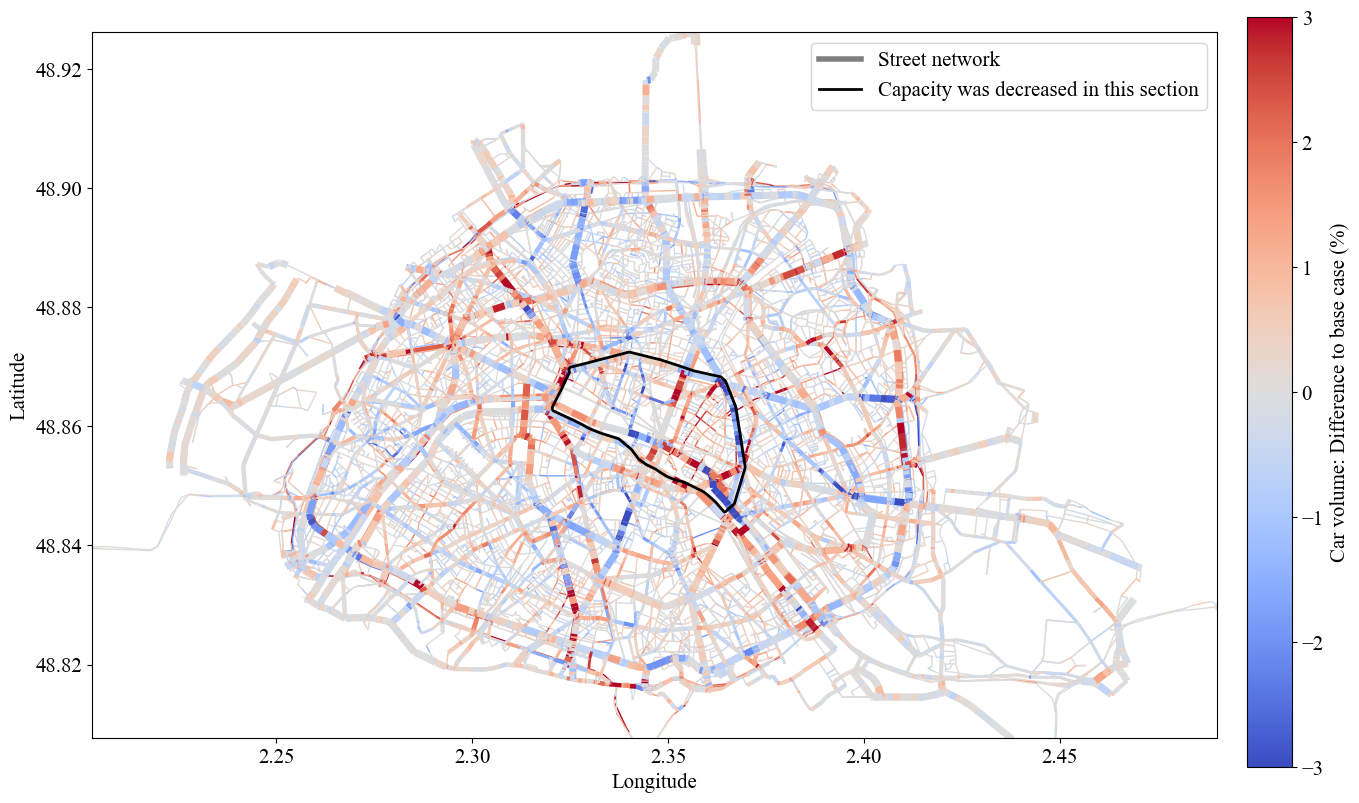

In [ ]:
fixed_norm_max = 3
gdf = hf.data_to_geodataframe(data=test_dl.dataset, original_gdf=test_data, predicted_values=predictions)
gdf_with_og_values = hf.map_to_original_values(input_gdf=gdf, scaler_x =scaler_x)
hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_predicted", 
                        save_it=True, number_to_plot=None, zone_to_plot = zone_to_plot, is_predicted=True, alpha=0, use_fixed_norm=True, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = True, buffer = 0.0005, districts_of_interest=districts_of_interest)
hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_actual", save_it=True, 
                        number_to_plot=None, zone_to_plot = zone_to_plot,is_predicted=False,alpha=10,use_fixed_norm=True, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = True, buffer = 0.0005, districts_of_interest=districts_of_interest)

In [ ]:
gdf = hf.data_to_geodataframe(data=test_dl.dataset, original_gdf=test_data, predicted_values=predictions)
gdf_with_og_values = hf.map_to_original_values(input_gdf=gdf, scaler_x =scaler_x)
gdf_in_meters = gdf_with_og_values.to_crs("EPSG:32633")
gdf_in_meters.length

tolerance = 1e-3
gdf_with_capacity_reduction = gdf_in_meters.loc[indices_to_filter_for]
gdf_with_capacity_reduction['length'] = gdf_with_capacity_reduction.length
total_length = gdf_with_capacity_reduction['length'].sum()/1000

In [ ]:
total_length

939.8766595801715